# Customer Retention Analysis and RFM Segmentation in E-commerce

## Dataset Overview
- **Source:** Kaggle (E-commerce Purchase History from Electronics Store), provider: REES46 Marketing Platform  
- **Scale:** ~2.6M purchase events; multiple items per `order_id`  
- **Goal:** Understand repeat purchasing behavior and customer value concentration; build RFM-based segments for actionable retention strategies  

## Objectives
1) Quantify customer retention patterns across time using cohort analysis  
2) Identify high-value customers through RFM (Recency, Frequency, Monetary) analytics  
3) Segment customers into actionable groups to inform targeted retention and marketing strategies  

## Import Required Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

## Load Dataset

In [2]:
from pathlib import Path
DATA_PATH = Path("../data/kz.csv")  # robust across OS
df = pd.read_csv(DATA_PATH, low_memory=False)

## Dataset Preview

In [3]:
df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18


## Dataset Info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2633521 entries, 0 to 2633520
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   order_id       int64  
 2   product_id     int64  
 3   category_id    float64
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        float64
dtypes: float64(3), int64(2), object(3)
memory usage: 160.7+ MB


**Observation:** `event_time` is `object`; all identifiers are numeric (`order_id`, `product_id` as int; `user_id`, `category_id` as float). IDs should be strings to prevent precision loss. `event_time` should be parsed as datetime (UTC).

## Load the dataset with Explicit Dtypes and Parsed Timestamps


In [5]:
dtype_map = {
    "order_id": "string",
    "user_id": "string",
    "product_id": "string",
    "category_id": "string",
    "category_code": "string",
    "brand": "string",
    "price": "float32",
}

df = pd.read_csv(
    DATA_PATH,
    dtype=dtype_map,
    parse_dates=["event_time"],
    low_memory=False
)

df["event_time"] = pd.to_datetime(df["event_time"], utc=True, errors="coerce")

## Dataset Info After Schema Definition

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2633521 entries, 0 to 2633520
Data columns (total 8 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   order_id       string             
 2   product_id     string             
 3   category_id    string             
 4   category_code  string             
 5   brand          string             
 6   price          float32            
 7   user_id        string             
dtypes: datetime64[ns, UTC](1), float32(1), string(6)
memory usage: 150.7 MB


## Dataset Dimensions

In [7]:
df.shape

(2633521, 8)

## Date Coverage

In [8]:
df["event_time"].min(), df["event_time"].max()

(Timestamp('1970-01-01 00:33:40+0000', tz='UTC'),
 Timestamp('2020-11-21 10:10:30+0000', tz='UTC'))

**Observation:** Minimum timestamp shows 1970-01-01, indicating invalid entries

## Validate Event Time

In [9]:
before_2020 = (df["event_time"] < "2020-01-01").sum()
nat_count   = df["event_time"].isna().sum()
print("Rows before 2020-01-01:", before_2020)
print("Rows with NaT:", nat_count)

df.loc[df["event_time"] < "2020-01-01", "event_time"].head()

Rows before 2020-01-01: 19631
Rows with NaT: 0


28813   1970-01-01 00:33:40+00:00
28814   1970-01-01 00:33:40+00:00
28815   1970-01-01 00:33:40+00:00
28816   1970-01-01 00:33:40+00:00
28817   1970-01-01 00:33:40+00:00
Name: event_time, dtype: datetime64[ns, UTC]

## Filter event_time to 2020

In [10]:
total_before = len(df)
mask_valid = (df["event_time"] >= "2020-01-01") & (df["event_time"] <= "2020-12-31")
removed = (~mask_valid).sum()
df = df.loc[mask_valid].reset_index(drop=True)

print("Removed rows:", removed, f"({removed/total_before:.2%})")
print("Rows after clean:", len(df))

Removed rows: 19631 (0.75%)
Rows after clean: 2613890


## Date coverage after filtering

In [11]:
df["event_time"].min(), df["event_time"].max()

(Timestamp('2020-01-05 03:26:46+0000', tz='UTC'),
 Timestamp('2020-11-21 10:10:30+0000', tz='UTC'))

## Missing values

In [12]:
na_pct = (
    df.isna()
      .mean()
      .mul(100)
      .round(2)
      .sort_values(ascending=False)
)
na_pct

user_id          78.47
category_code    23.23
brand            19.18
category_id      16.37
price            16.37
event_time        0.00
order_id          0.00
product_id        0.00
dtype: float64

**Observation:** The dataset shows substantial missingness, with user_id absent in 78.47% of rows. Notable gaps are also present in category_code (23.23%), brand (19.18%), and both category_id and price (16.37% each). In contrast, event_time is fully complete, ensuring reliable temporal analysis.

## Assess user_id availability

In [13]:
rows_total = len(df)
rows_with_uid = df["user_id"].notna().sum()
unique_users  = df.loc[df["user_id"].notna(), "user_id"].nunique()
orders_with_uid = df.loc[df["user_id"].notna(), "order_id"].nunique()

print("Rows with user_id:", rows_with_uid, f"({rows_with_uid/rows_total:.2%})")
print("Unique users:", unique_users)
print("Orders with user_id:", orders_with_uid)

Rows with user_id: 562862 (21.53%)
Unique users: 233575
Orders with user_id: 399750


## Subset transactions with valid user_id

In [14]:
df_uid = df[df["user_id"].notna()].copy()
len(df_uid), df_uid["user_id"].nunique(), df_uid["order_id"].nunique()

(562862, 233575, 399750)

## Price sanity check (user_id subset)

In [15]:
null_price   = df_uid["price"].isna().sum()
non_positive = (df_uid["price"] <= 0).sum()
summary      = df_uid["price"].describe(percentiles=[.5, .75, .9, .95, .99])

print("Null price:", null_price)
print("Non-positive price (<=0):", non_positive)
summary

Null price: 0
Non-positive price (<=0): 39


count    562862.000000
mean        208.435089
std         304.547638
min           0.000000
50%          87.940002
75%         277.750000
90%         543.960022
95%         856.229980
99%        1385.390015
max       18328.679688
Name: price, dtype: float64

## Remove invalid prices (user_id subset)

In [16]:
before = len(df_uid)
df_uid = df_uid[df_uid["price"] > 0].reset_index(drop=True)
removed = before - len(df_uid)
print("Removed non-positive prices:", removed, f"({removed/before:.4%})")

Removed non-positive prices: 39 (0.0069%)


Non-positive prices were negligible (39 rows; 0.0069%) and have been removed.

## Standardize brand and category_code

In [17]:
df_uid["brand"] = df_uid["brand"].str.lower().str.strip()
df_uid["category_code"] = df_uid["category_code"].str.lower().str.strip()

## Backfill category_code from category_id

In [18]:
cat_map = (
    df_uid.dropna(subset=["category_id","category_code"])
          .groupby("category_id")["category_code"]
          .agg(lambda s: s.value_counts().idxmax())
)

df_uid["category_code"] = df_uid["category_code"].fillna(df_uid["category_id"].map(cat_map))
df_uid["category_code"] = df_uid["category_code"].fillna("unknown")
df_uid["brand"] = df_uid["brand"].fillna("unknown")

## Missingness after fills (user_id subset)

In [19]:
df_uid[["brand","category_id","category_code"]].isna().mean().mul(100).round(2)

brand            0.0
category_id      0.0
category_code    0.0
dtype: float64

## Validate order -> user consistency 

In [20]:
# Each order_id should belong to exactly one user_id
users_per_order = df_uid.groupby("order_id")["user_id"].nunique()
inconsistent_orders = (users_per_order > 1).sum()
print("Orders with >1 user_id:", inconsistent_orders)

Orders with >1 user_id: 0


## Build orders table

In [21]:
# Helper to pick the most frequent user_id per order (in case of anomalies)
def most_frequent(s):
    return s.value_counts().idxmax()

orders = (
    df_uid.groupby("order_id").agg(
        user_id=("user_id", most_frequent),
        order_dt=("event_time", "max"),
        order_revenue=("price", "sum"),
        items=("product_id", "count"),
        distinct_products=("product_id", "nunique"),
        distinct_categories=("category_code", "nunique"),
        distinct_brands=("brand", "nunique")
    )
    .reset_index()
)

orders.shape, orders.head(3)

((399728, 8),
               order_id              user_id                  order_dt  order_revenue  items  distinct_products  \
 0  2294359932054536986  1515915625441993984 2020-04-24 11:50:39+00:00     324.019989      2                  1   
 1  2294444024058086220  1515915625447879434 2020-04-24 14:37:43+00:00     155.039993      2                  1   
 2  2294584263154074236  1515915625443148002 2020-04-24 19:16:21+00:00     217.570007      1                  1   
 
    distinct_categories  distinct_brands  
 0                    1                1  
 1                    1                1  
 2                    1                1  )

## Sanity on orders

In [22]:
print("Zero/negative revenue orders:", (orders["order_revenue"] <= 0).sum())
orders["order_revenue"].describe(percentiles=[.5,.75,.9,.95,.99])

Zero/negative revenue orders: 0


count    399728.000000
mean        293.500153
std         396.883911
min           0.020000
50%         149.004997
75%         393.500000
90%         810.159973
95%        1041.640015
99%        1712.887223
max       18699.029297
Name: order_revenue, dtype: float64

## Check last few records of Order Revenue

In [23]:
q = orders["order_revenue"].quantile([0.95, 0.99, 0.995, 0.999])
tail_counts = {
    "above_p99": (orders["order_revenue"] > q.loc[0.99]).sum(),
    "above_p995": (orders["order_revenue"] > q.loc[0.995]).sum(),
    "above_p999": (orders["order_revenue"] > q.loc[0.999]).sum(),
}
q, tail_counts

(0.950    1041.640015
 0.990    1712.887223
 0.995    2145.713615
 0.999    3472.199951
 Name: order_revenue, dtype: float64,
 {'above_p99': 3998, 'above_p995': 1999, 'above_p999': 398})

## Winsorize order_revenue at P99.5

In [24]:
cap = orders["order_revenue"].quantile(0.995)
orders["order_revenue_cap"] = orders["order_revenue"].clip(upper=cap)

orders[["order_revenue","order_revenue_cap"]].describe(percentiles=[.5,.75,.9,.95,.99])

,order_revenue,order_revenue_cap
count,399728.000000,399728.000000
mean,293.500153,289.415992
std,396.883911,365.747108
min,0.020000,0.020000
50%,149.004997,149.004997
75%,393.500000,393.500000
90%,810.159973,810.159973
95%,1041.640015,1041.640015
99%,1712.887223,1712.887223
max,18699.029297,2145.713615


## Summary metrics

In [25]:
# Core counts
total_orders = len(orders)
unique_users = orders["user_id"].nunique()

# Revenue (winsorized for robustness)
total_revenue_cap = orders["order_revenue_cap"].sum()
median_aov = orders["order_revenue_cap"].median()
mean_aov = orders["order_revenue_cap"].mean()

# Basket depth
median_items = orders["items"].median()
mean_items = orders["items"].mean()

# Time coverage from orders
date_start = orders["order_dt"].min()
date_end   = orders["order_dt"].max()

print(f"Orders: {total_orders:,}")
print(f"Unique users: {unique_users:,}")
print(f"Revenue (winsorized): {total_revenue_cap:,.2f}")
print(f"AOV (median / mean): {median_aov:.2f} / {mean_aov:.2f}")
print(f"Items per order (median / mean): {median_items:.0f} / {mean_items:.2f}")
print(f"Coverage: {date_start} → {date_end}")

Orders: 399,728
Unique users: 233,566
Revenue (winsorized): 115,687,675.63
AOV (median / mean): 149.00 / 289.42
Items per order (median / mean): 1 / 1.41
Coverage: 2020-01-05 04:01:46+00:00 → 2020-11-21 10:10:30+00:00


## Order revenue distribution (winsorized)

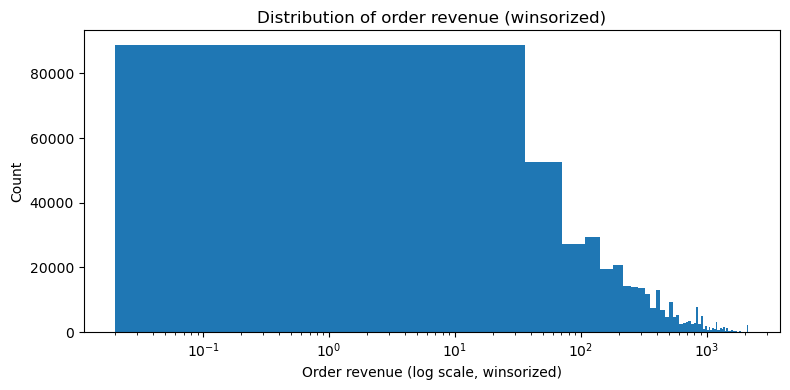

In [26]:
vals = orders["order_revenue_cap"].values

plt.figure(figsize=(8,4))
plt.hist(vals, bins=60)
plt.xscale("log")
plt.xlabel("Order revenue (log scale, winsorized)")
plt.ylabel("Count")
plt.title("Distribution of order revenue (winsorized)")
plt.tight_layout()

**Observation:** Most orders are relatively small in value, concentrated below a few hundred units. A much smaller share of orders are very large — with some extreme cases reaching ~18,699 before capping — highlighting a classic “few big orders, many small orders” pattern.

## Items per order distribution

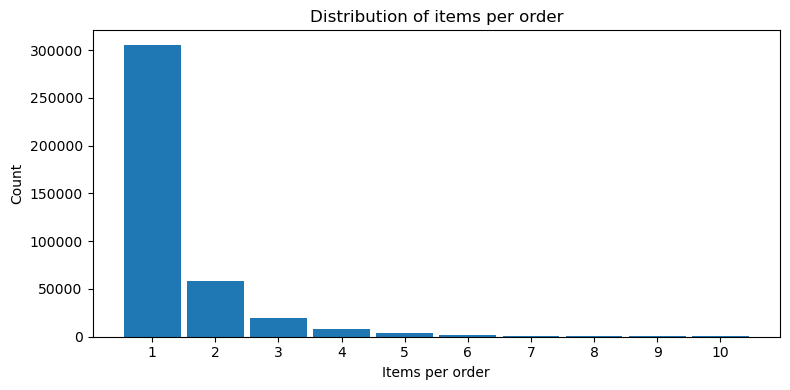

In [27]:
plt.figure(figsize=(8,4))
plt.hist(orders["items"], bins=range(1, 12), align="left", rwidth=0.9)
plt.xlabel("Items per order")
plt.ylabel("Count")
plt.title("Distribution of items per order")
plt.xticks(range(1, 11))
plt.tight_layout()

**Observation:** Most purchases consist of a single item, with multi-item baskets becoming increasingly rare beyond two or three products. This highlights that customers typically buy specific items rather than filling carts, suggesting opportunities to encourage cross-selling or bundling strategies.

## Monthly trend: orders and revenue (2020)

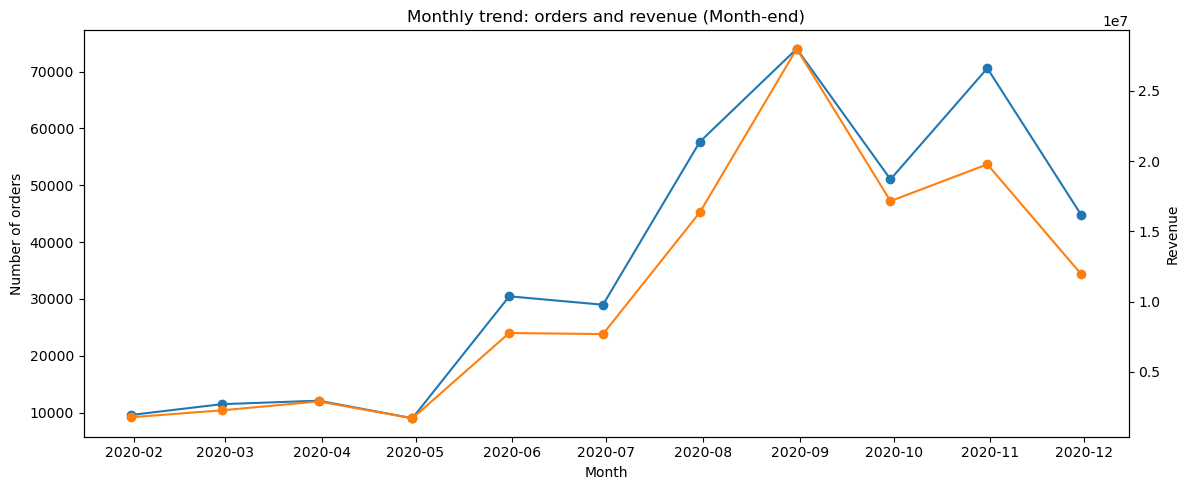

In [28]:
## Monthly trend: orders and revenue (2020)
monthly = (
    orders
    .set_index("order_dt")
    .resample("ME")
    .agg(
        orders=("order_id", "nunique"),
        revenue=("order_revenue", "sum")
    )
)

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(monthly.index, monthly["orders"], marker="o", color="tab:blue", label="Orders")
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of orders")

ax2 = ax1.twinx()
ax2.plot(monthly.index, monthly["revenue"], marker="o", color="tab:orange", label="Revenue")
ax2.set_ylabel("Revenue")

plt.title("Monthly trend: orders and revenue (Month-end)")
fig.tight_layout()
plt.show()

**Observation:** Orders and revenue increased steadily from January, peaking in August and again in October, before declining in November. The pattern indicates stronger demand in late summer and early fall, with weaker activity at the start and end of the year. These fluctuations suggest seasonal effects and highlight months where additional promotional focus could help balance sales performance.

## Top categories by revenue

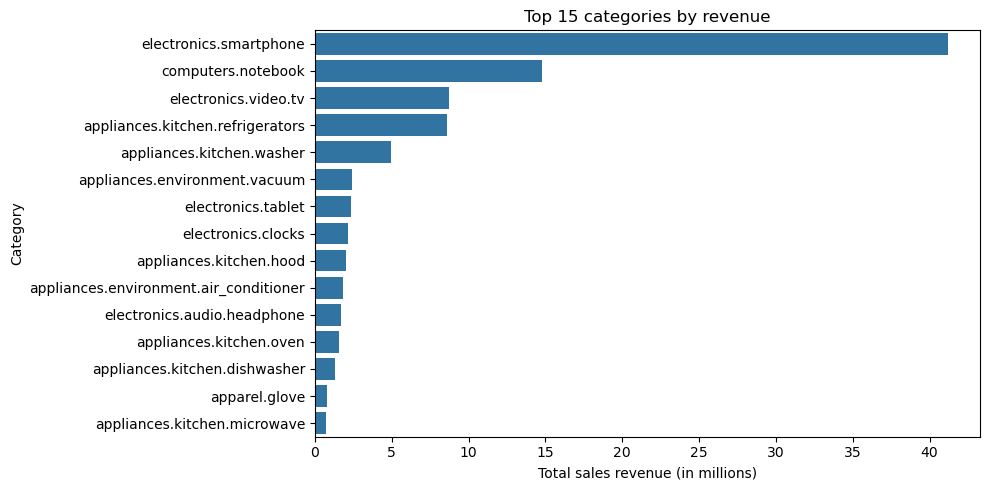

In [29]:
cat_rev_m = (
    df_uid[df_uid["category_code"] != "unknown"]
      .groupby("category_code")["price"]
      .sum()
      .sort_values(ascending=False)
      .head(15) / 1e6
)

plt.figure(figsize=(10,5))
sns.barplot(x=cat_rev_m.values, y=cat_rev_m.index)
plt.xlabel("Total sales revenue (in millions)")
plt.ylabel("Category")
plt.title("Top 15 categories by revenue")
plt.tight_layout()
plt.show()

**Observation:** Smartphones and notebooks dominate sales, with smartphones alone generating over 40 million in revenue, far surpassing all other categories. Televisions and large kitchen appliances such as refrigerators and washers make up the next tier, while the remaining categories contribute much smaller amounts. This concentration highlights strong dependence on a few high-demand electronics categories, suggesting limited diversification across the wider product mix.

## Top brands by revenue

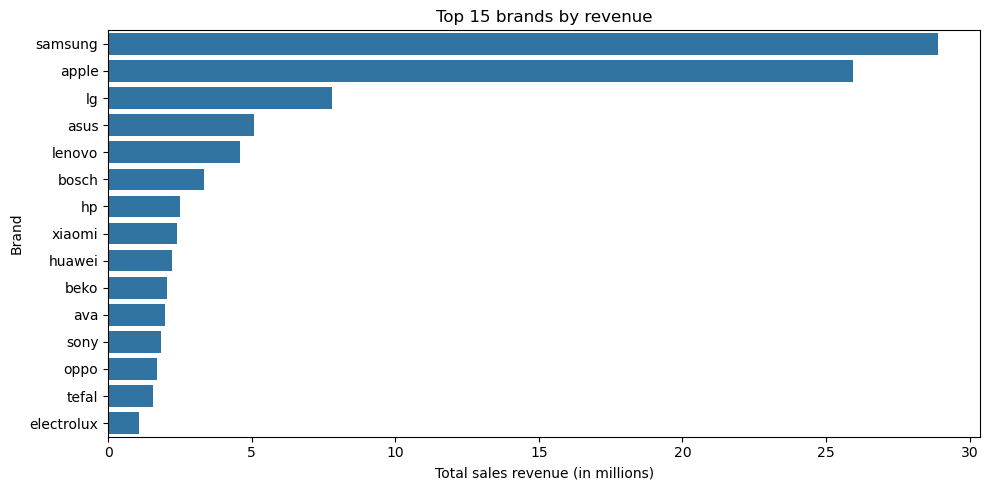

In [30]:
## Top 15 brands by revenue (in millions)
brand_rev_m = (
    df_uid[df_uid["brand"] != "unknown"]
    .groupby("brand")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(15) / 1e6
)

plt.figure(figsize=(10,5))
sns.barplot(x=brand_rev_m.values, y=brand_rev_m.index)
plt.xlabel("Total sales revenue (in millions)")
plt.ylabel("Brand")
plt.title("Top 15 brands by revenue")
plt.tight_layout()
plt.show()

**Observation:** Sales are dominated by a small number of leading brands, with Samsung and Apple far ahead of all others, each contributing over 25 million in revenue. LG, Asus, and Lenovo form a secondary tier, while the remaining brands generate much smaller shares. This concentration shows strong brand preference among customers and indicates that market performance is heavily influenced by a few key players.

## Revenue concentration by users 

Revenue share — top 5% users:   34.3%
Revenue share — top 10% users:  49.0%
Revenue share — top 20% users:  67.8%


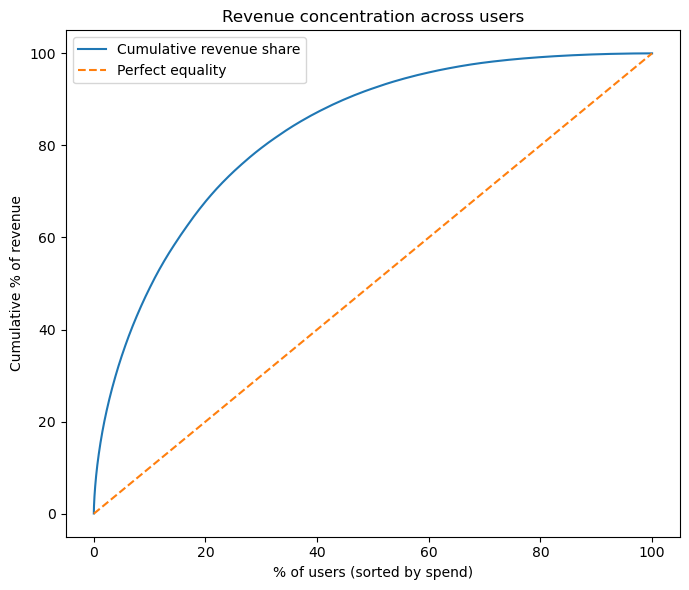

In [31]:
user_rev = (
    orders.groupby("user_id")["order_revenue_cap"]
          .sum()
          .sort_values(ascending=False)
          .reset_index(name="revenue")
)

n = len(user_rev)
user_rev["cum_users_pct"] = (np.arange(1, n+1) / n) * 100
user_rev["cum_rev_pct"]   = user_rev["revenue"].cumsum() / user_rev["revenue"].sum() * 100

# Quick stats: revenue share captured by top X% users
share_top_5  = user_rev.loc[int(0.05*n)-1, "cum_rev_pct"]
share_top_10 = user_rev.loc[int(0.10*n)-1, "cum_rev_pct"]
share_top_20 = user_rev.loc[int(0.20*n)-1, "cum_rev_pct"]
print(f"Revenue share — top 5% users:  {share_top_5:5.1f}%")
print(f"Revenue share — top 10% users: {share_top_10:5.1f}%")
print(f"Revenue share — top 20% users: {share_top_20:5.1f}%")

# Plot contribution curve (Lorenz-style)
plt.figure(figsize=(7,6))
plt.plot(user_rev["cum_users_pct"], user_rev["cum_rev_pct"], label="Cumulative revenue share")
plt.plot([0,100], [0,100], linestyle="--", label="Perfect equality")
plt.xlabel("% of users (sorted by spend)")
plt.ylabel("Cumulative % of revenue")
plt.title("Revenue concentration across users")
plt.legend()
plt.tight_layout()
plt.show()

**Observation:** A small group of high-spending users contributes a disproportionately large share of total revenue. Roughly the top 10% of users generate the majority of sales, while the remaining users contribute relatively little.

## Build monthly cohorts (first purchase month -> subsequent activity)

In [32]:
def month_start(ts):
    return pd.Timestamp(ts.year, ts.month, 1, tz=ts.tz)

# Order month and cohort (first purchase month per user)
orders_coh = orders.copy()
orders_coh["order_month"] = orders_coh["order_dt"].apply(month_start)

first_order = (
    orders_coh.groupby("user_id")["order_month"]
              .min()
              .rename("cohort_month")
)

orders_coh = orders_coh.merge(first_order, on="user_id", how="left")

# Cohort period index: 0 for first month, 1 for next month, etc.
orders_coh["cohort_period"] = (
    (orders_coh["order_month"].dt.year - orders_coh["cohort_month"].dt.year) * 12
    + (orders_coh["order_month"].dt.month - orders_coh["cohort_month"].dt.month)
).astype(int)

# Cohort sizes (unique users in month 0)
cohort_sizes = (
    orders_coh[orders_coh["cohort_period"] == 0]
    .groupby("cohort_month")["user_id"].nunique()
    .rename("cohort_size")
)

# Active users per cohort-period
active_users = (
    orders_coh.groupby(["cohort_month", "cohort_period"])["user_id"]
              .nunique()
              .rename("active_users")
              .reset_index()
)

# Retention table (% of cohort active each month)
retention = active_users.merge(cohort_sizes, on="cohort_month", how="left")
retention["retention_pct"] = (retention["active_users"] / retention["cohort_size"] * 100).round(2)

# Pivot for quick view (rows = cohort month, cols = period 0..N)
retention_pivot = retention.pivot(index="cohort_month", columns="cohort_period", values="retention_pct").sort_index()

# Show the first few cohorts
retention_pivot.fillna(0).head()

cohort_period,0,1,2,3,4,5,6,7,8,9,10
cohort_month,,,,,,,,,,,
2020-01-01 00:00:00+00:00,100.0,24.86,17.54,6.91,13.85,18.98,11.19,12.86,16.03,6.44,5.34
2020-02-01 00:00:00+00:00,100.0,19.89,5.82,12.63,17.34,9.57,12.49,14.60,5.57,5.15,0.00
2020-03-01 00:00:00+00:00,100.0,7.77,15.58,18.60,10.40,12.34,15.25,6.05,4.33,0.00,0.00
2020-04-01 00:00:00+00:00,100.0,13.30,9.56,9.11,9.46,7.96,4.90,2.93,0.00,0.00,0.00
2020-05-01 00:00:00+00:00,100.0,12.01,8.35,8.06,6.43,3.70,2.09,0.00,0.00,0.00,0.00


## Cohort retention heatmap

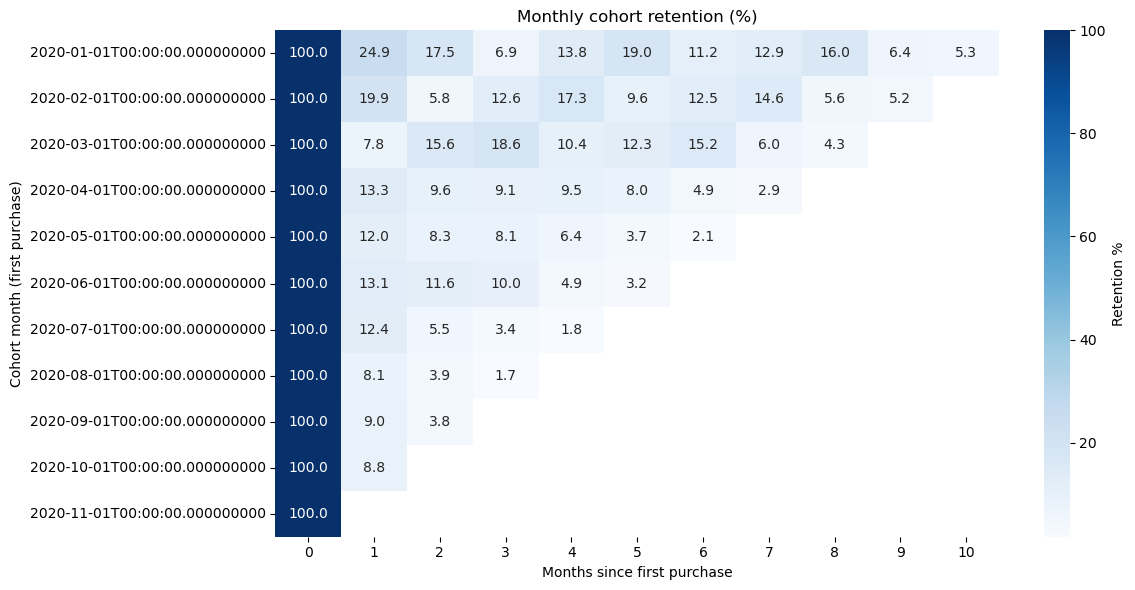

In [33]:
plt.figure(figsize=(12,6))
sns.heatmap(retention_pivot, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Retention %'})
plt.title("Monthly cohort retention (%)")
plt.ylabel("Cohort month (first purchase)")
plt.xlabel("Months since first purchase")
plt.tight_layout()
plt.show()

**Observation:**  Month+1 retention ranges roughly from the low teens to ~25% depending on cohort (e.g., Jan ≈ 24.9%, Apr ≈ 13.3%), then decays steadily to low single digits by Month+6–10. Overall, the pattern indicates fast early drop-off with a small core of repeat buyers persisting across several months.

## Build user-level RFM table

In [34]:
users = (
    orders.groupby("user_id").agg(
        last_order_dt = ("order_dt", "max"),
        first_order_dt= ("order_dt", "min"),
        frequency     = ("order_id", "count"),
        monetary      = ("order_revenue_cap", "sum")
    ).reset_index()
)

# Reference date for recency (day after the last observed order)
ref_date = orders["order_dt"].max() + pd.Timedelta(days=1)

users["recency_days"] = (ref_date - users["last_order_dt"]).dt.days
users["tenure_days"]  = (users["last_order_dt"] - users["first_order_dt"]).dt.days

users.head()

,user_id,last_order_dt,first_order_dt,frequency,monetary,recency_days,tenure_days
0,1515915625439952115,2020-07-09 06:35:18+00:00,2020-07-09 06:35:18+00:00,1,416.640015,136,0
1,1515915625440038436,2020-10-28 05:53:47+00:00,2020-09-22 15:11:15+00:00,2,56.430000,25,35
2,1515915625440051468,2020-11-16 15:49:50+00:00,2020-10-21 12:23:18+00:00,5,3158.683620,5,26
3,1515915625440099873,2020-11-08 23:48:43+00:00,2020-05-12 05:56:43+00:00,19,5074.469964,13,180
4,1515915625440121544,2020-07-14 13:04:12+00:00,2020-05-16 16:09:13+00:00,2,182.829994,130,58


## RFM scoring (quantiles 1–5) and segment labels


In [35]:
def qscore(series, q=5, reverse=False):
    # small jitter to reduce identical-cut issues (does not change rank meaningfully)
    s = series.astype(float) + np.random.default_rng(42).normal(0, 1e-9, len(series))
    bins = pd.qcut(s, q, labels=False, duplicates="drop") + 1  # 1..q
    if reverse:  # smaller is better (recency)
        bins = (q + 1) - bins
    return bins.astype(int)

users["R"] = qscore(users["recency_days"], q=5, reverse=True)     # smaller recency → higher score
users["F"] = qscore(users["frequency"],     q=5, reverse=False)   # more orders → higher score
users["M"] = qscore(users["monetary"],      q=5, reverse=False)   # higher spend → higher score

# Compact RFM code and an initial segment label
users["RFM_code"] = users["R"].astype(str) + users["F"].astype(str) + users["M"].astype(str)

def label_segment(row):
    if row["R"] >= 4 and row["F"] >= 4 and row["M"] >= 4:
        return "Champions"
    if row["R"] >= 4 and row["F"] >= 3:
        return "Loyal (recent)"
    if row["R"] <= 2 and row["F"] >= 4:
        return "At risk (loyal lapsed)"
    if row["R"] >= 3 and row["F"] <= 2 and row["M"] <= 2:
        return "New/Promising"
    if row["R"] <= 2 and row["F"] <= 2 and row["M"] <= 2:
        return "Hibernating"
    return "Regulars"

users["segment"] = users.apply(label_segment, axis=1)

# Quick sanity: segment sizes and revenue share
seg_summary = (
    users.groupby("segment").agg(
        users=("user_id","count"),
        revenue=("monetary","sum"),
        freq_med=("frequency","median"),
        recency_med=("recency_days","median")
    )
    .sort_values("revenue", ascending=False)
)
seg_summary["revenue_share_%"] = (seg_summary["revenue"] / seg_summary["revenue"].sum() * 100).round(2)
seg_summary

,users,revenue,freq_med,recency_med,revenue_share_%
segment,,,,,
Regulars,97355,5.496373e+07,1.0,96.0,47.51
Champions,20670,2.987826e+07,3.0,28.0,25.83
At risk (loyal lapsed),33469,2.204996e+07,2.0,137.0,19.06
Loyal (recent),34362,6.478319e+06,1.0,25.0,5.60
New/Promising,27057,1.312341e+06,1.0,34.0,1.13
Hibernating,20653,1.005060e+06,1.0,166.0,0.87


**Observation:** Revenue is concentrated in a few segments. “Regulars” contribute ~47.5% of revenue (median recency ≈ 96 days, frequency ≈ 1), while a much smaller group of “Champions” (≈20.7k users) delivers ~25.8% with higher purchase frequency (median 3) and recent activity (median recency ≈ 28 days). “At risk (loyal lapsed)” still drives ~19% but shows long inactivity (median recency ≈ 137 days), indicating clear win-back potential. Other segments contribute marginally.

## Segment distribution and revenue share

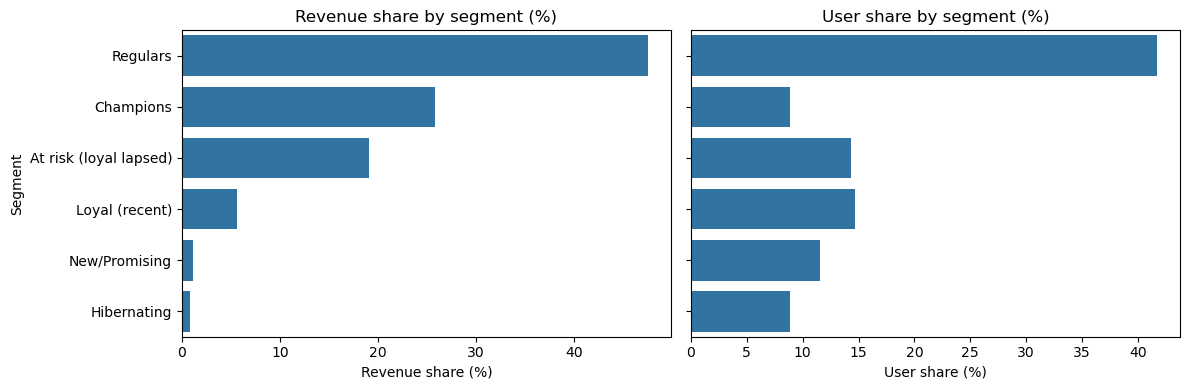

,segment,users,user_share_pct,revenue,rev_share_pct
0,Regulars,97355,41.68,54963732.01,47.51
1,Champions,20670,8.85,29878262.95,25.83
2,At risk (loyal lapsed),33469,14.33,22049960.68,19.06
3,Loyal (recent),34362,14.71,6478319.40,5.60
4,New/Promising,27057,11.58,1312340.99,1.13
5,Hibernating,20653,8.84,1005059.60,0.87


In [36]:
seg_plot = (
    users.groupby("segment")
         .agg(users=("user_id","count"), revenue=("monetary","sum"))
         .assign(user_share_pct=lambda d: d["users"]/d["users"].sum()*100,
                 rev_share_pct =lambda d: d["revenue"]/d["revenue"].sum()*100)
         .sort_values("rev_share_pct", ascending=False)
         .reset_index()
)

# Plot users share and revenue share
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

sns.barplot(data=seg_plot, x="rev_share_pct", y="segment", ax=axes[0])
axes[0].set_title("Revenue share by segment (%)")
axes[0].set_xlabel("Revenue share (%)"); axes[0].set_ylabel("Segment")

sns.barplot(data=seg_plot, x="user_share_pct", y="segment", ax=axes[1])
axes[1].set_title("User share by segment (%)")
axes[1].set_xlabel("User share (%)"); axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

seg_plot[["segment","users","user_share_pct","revenue","rev_share_pct"]].round(2)

**Observation:**
The majority of users are “Regulars” (≈42% of the base), contributing nearly half of total revenue (47.5%). “Champions” form a much smaller group (≈9% of users) but contribute about 25.8% of revenue, underlining their strategic importance. The “At risk (loyal lapsed)” group is also critical: while ≈14% of users, they still generate about 19% of revenue despite long inactivity, highlighting a clear opportunity for re-engagement campaigns. The remaining segments (“Loyal recent,” “New/Promising,” and “Hibernating”) together account for ≈15% of revenue, suggesting more limited but still valuable growth potential.

## Per-segment KPIs (size, revenue, recency, frequency, AOV)

In [37]:
seg_users = (
    users.groupby("segment").agg(
        users=("user_id","count"),
        revenue=("monetary","sum"),
        recency_med=("recency_days","median"),
        freq_med=("frequency","median")
    )
)

# order-side AOV (winsorized) per segment
orders_seg = orders.merge(users[["user_id","segment"]], on="user_id", how="left")
aov_seg = (
    orders_seg.groupby("segment")["order_revenue_cap"]
              .median()
              .rename("aov_median")
)

# combine + revenue share
seg_kpis = (
    seg_users.join(aov_seg, how="left")
             .assign(revenue_share_pct=lambda d: d["revenue"]/d["revenue"].sum()*100)
             .sort_values("revenue_share_pct", ascending=False)
)

seg_kpis.round({"revenue":2,"revenue_share_pct":2,"aov_median":2})

,users,revenue,recency_med,freq_med,aov_median,revenue_share_pct
segment,,,,,,
Regulars,97355,54963732.01,96.0,1.0,249.98,47.51
Champions,20670,29878262.95,28.0,3.0,252.27,25.83
At risk (loyal lapsed),33469,22049960.68,137.0,2.0,138.87,19.06
Loyal (recent),34362,6478319.40,25.0,1.0,56.65,5.60
New/Promising,27057,1312340.99,34.0,1.0,40.49,1.13
Hibernating,20653,1005059.60,166.0,1.0,37.01,0.87


## Actions by segment
- **Champions** (high value, recent, frequent): Reward with loyalty perks, early access, exclusive products. Avoid heavy discounts.  
- **Regulars** (large base, moderate recency): Encourage repeat orders with bundles, personalized recommendations, or free-shipping thresholds.  
- **At risk (loyal lapsed)** (once frequent/high spend, now inactive): Run win-back campaigns at 90–150 days (targeted discounts, reminders, personalized offers).  
- **Loyal (recent)** (active but low order frequency): Nurture with second-order promotions and onboarding campaigns.  
- **New/Promising** (first-time or very early customers): Focus on conversion to second order (welcome offers, product education).  
- **Hibernating** (long inactive, low spend): Low-cost reactivation attempts or suppression to avoid wasted marketing spend.  

## Build user-level clustering features (RFM + items/order, interpurchase gaps, category/brand diversity)

In [38]:
# Base: RFM + tenure
feat = users[["user_id", "recency_days", "frequency", "monetary", "tenure_days"]].copy()

#  Items per order (average basket size) 
user_items = (
    orders.groupby("user_id")["items"]
          .mean()
          .rename("avg_items_per_order")
)
feat = feat.merge(user_items, on="user_id", how="left")

# Interpurchase gaps (days): mean & std, warning-free
ord_sorted = orders.sort_values(["user_id", "order_dt"]).copy()
gaps_days  = ord_sorted.groupby("user_id")["order_dt"].diff().dt.days  # Series aligned to ord_sorted

gaps = (
    gaps_days.groupby(ord_sorted["user_id"]).agg(gap_mean="mean", gap_std="std")
             .reset_index()
)
feat = feat.merge(gaps, on="user_id", how="left")

# Category/brand diversity (line-item view)
diversity = (
    df_uid.groupby("user_id").agg(
        unique_categories=("category_code", "nunique"),
        unique_brands=("brand", "nunique")
    )
    .reset_index()
)
feat = feat.merge(diversity, on="user_id", how="left")

# Final tidy-up: fill NaNs created by single-order users / missing labels
feat[["avg_items_per_order", "gap_mean", "gap_std", "unique_categories", "unique_brands"]] = (
    feat[["avg_items_per_order", "gap_mean", "gap_std", "unique_categories", "unique_brands"]]
    .fillna(0)
)

print("Feature rows:", len(feat))
feat.head()

Feature rows: 233566


,user_id,recency_days,frequency,monetary,tenure_days,avg_items_per_order,gap_mean,gap_std,unique_categories,unique_brands
0,1515915625439952115,136,1,416.640015,0,1.000000,0.000000,0.000000,1,1
1,1515915625440038436,25,2,56.430000,35,1.000000,35.000000,0.000000,2,2
2,1515915625440051468,5,5,3158.683620,26,2.800000,6.250000,11.842719,7,9
3,1515915625440099873,13,19,5074.469964,180,1.263158,9.666667,17.776389,7,13
4,1515915625440121544,130,2,182.829994,58,1.000000,58.000000,0.000000,2,1


## Prepare features for clustering

In [39]:
feature_cols = [
    "recency_days","frequency","monetary","tenure_days",
    "avg_items_per_order","gap_mean","gap_std",
    "unique_categories","unique_brands"
]

X = feat[feature_cols].astype(float).copy()

# log1p for skewed, positive features
for c in ["recency_days","frequency","monetary","tenure_days",
          "gap_mean","gap_std","unique_categories","unique_brands"]:
    X[c] = np.log1p(X[c])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X.shape  # rows, cols

(233566, 9)

## Choose number of clusters

,k,inertia,silhouette,calinski_harabasz,davies_bouldin
0,3,1.026858e+06,0.456477,122696.652436,1.067186
1,4,9.043941e+05,0.274947,103570.458493,1.283197
2,5,7.311204e+05,0.293835,109577.170958,1.239801
3,6,6.711336e+05,0.306390,99785.798596,1.178681
4,7,5.950159e+05,0.295945,98879.390373,1.102946
5,8,5.468902e+05,0.294279,95091.845324,1.199035


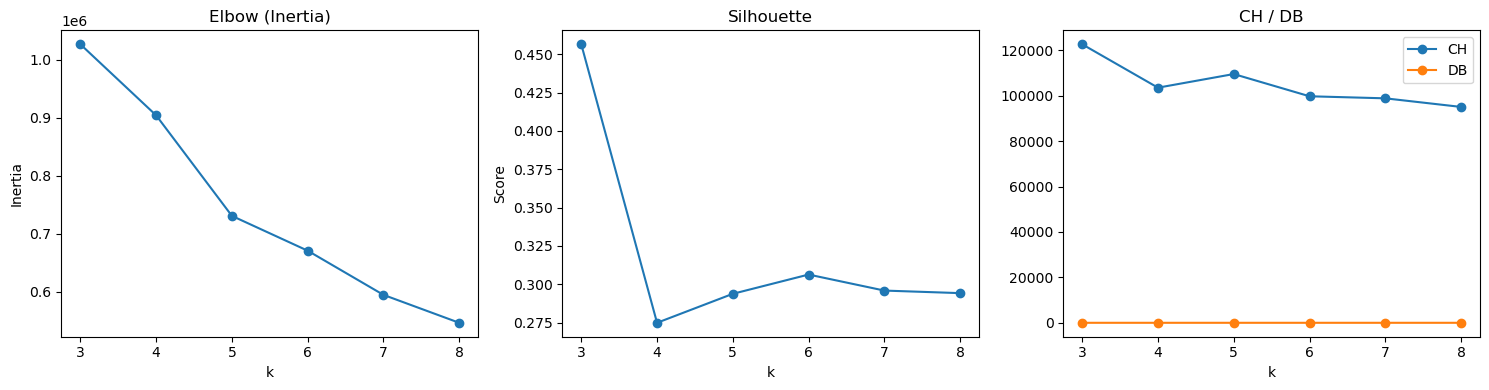

In [40]:
ks = range(3, 9)  
rows = []

for k in ks:
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048, n_init="auto")
    labels = km.fit_predict(X_scaled)
    rows.append({
        "k": k,
        "inertia": km.inertia_,
        "silhouette": silhouette_score(X_scaled, labels),
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),
        "davies_bouldin": davies_bouldin_score(X_scaled, labels),
    })

k_scores = pd.DataFrame(rows)
display(k_scores)

# Visuals
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].plot(k_scores["k"], k_scores["inertia"], marker="o"); axes[0].set_title("Elbow (Inertia)"); axes[0].set_xlabel("k"); axes[0].set_ylabel("Inertia")
axes[1].plot(k_scores["k"], k_scores["silhouette"], marker="o"); axes[1].set_title("Silhouette"); axes[1].set_xlabel("k"); axes[1].set_ylabel("Score")
axes[2].plot(k_scores["k"], k_scores["calinski_harabasz"], marker="o", label="CH")
axes[2].plot(k_scores["k"], k_scores["davies_bouldin"], marker="o", label="DB")
axes[2].set_title("CH / DB"); axes[2].set_xlabel("k"); axes[2].legend()
plt.tight_layout(); plt.show()

**Observation:** The elbow shows diminishing returns after k≈3–4; silhouette is highest at k=3 (~0.456) and drops for larger k; Calinski–Harabasz is highest at k=3 and Davies–Bouldin is lowest at k=3. Taken together, k=3 is the most defensible choice.

## Fit final model and assign clusters

In [41]:
K = 3
kmeans = MiniBatchKMeans(n_clusters=K, random_state=42, batch_size=2048, n_init="auto")
feat["cluster"] = kmeans.fit_predict(X_scaled)

# Join back to users to analyze spend/behavior by cluster
users_clusters = users.merge(feat[["user_id","cluster"]], on="user_id", how="left")
orders_clusters = orders.merge(feat[["user_id","cluster"]], on="user_id", how="left")

users_clusters["cluster"].value_counts().sort_index()

cluster
0     16402
1    172807
2     44357
Name: count, dtype: int64

## Map clusters to business personas

In [42]:
# Map numeric clusters to business-friendly names
cluster_name_map = {
    2: "High-Value Loyalists",
    1: "Mass-Market Regulars",
    0: "Occasional Mid-Value"
}

users_clusters["cluster_name"] = users_clusters["cluster"].map(cluster_name_map)
orders_clusters["cluster_name"] = orders_clusters["cluster"].map(cluster_name_map)

## Profile clusters (size, revenue share, medians)

In [45]:
# Cluster sizes and revenue (use business persona names)
clust_summary = (
    users_clusters.groupby("cluster_name")
      .agg(users=("user_id","count"),
           revenue=("monetary","sum"),
           recency_med=("recency_days","median"),
           freq_med=("frequency","median"),
           monetary_med=("monetary","median"))
      .assign(revenue_share_pct=lambda d: d["revenue"]/d["revenue"].sum()*100)
      .sort_values("revenue_share_pct", ascending=False)
)

# Add engineered-feature medians for extra context (still joined by cluster_name)
more_medians = (
    users_clusters.merge(feat[["user_id","cluster"]], on="user_id", how="left")  # optional safety
)

# Better: compute these medians directly from feat but map cluster -> cluster_name first
feat_named = feat.merge(users_clusters[["user_id", "cluster_name"]], on="user_id", how="left")

more_medians = (
    feat_named.groupby("cluster_name")
        .agg(tenure_med=("tenure_days","median"),
             items_med=("avg_items_per_order","median"),
             gap_mean_med=("gap_mean","median"),
             uniq_cat_med=("unique_categories","median"),
             uniq_brand_med=("unique_brands","median"))
)

clust_profile = clust_summary.join(more_medians)
clust_profile.round(2)

,users,revenue,recency_med,freq_med,monetary_med,revenue_share_pct,tenure_med,items_med,gap_mean_med,uniq_cat_med,uniq_brand_med
cluster_name,,,,,,,,,,,
Mass-Market Regulars,172807,57153012.26,92.0,1.0,145.81,49.40,0.0,1.00,0.0,1.0,1.0
High-Value Loyalists,44357,47839540.90,71.0,3.0,591.57,41.35,60.0,1.25,29.0,3.0,3.0
Occasional Mid-Value,16402,10695122.47,49.0,1.0,357.50,9.24,0.0,3.00,0.0,3.0,3.0


## Visualization: cluster revenue vs users

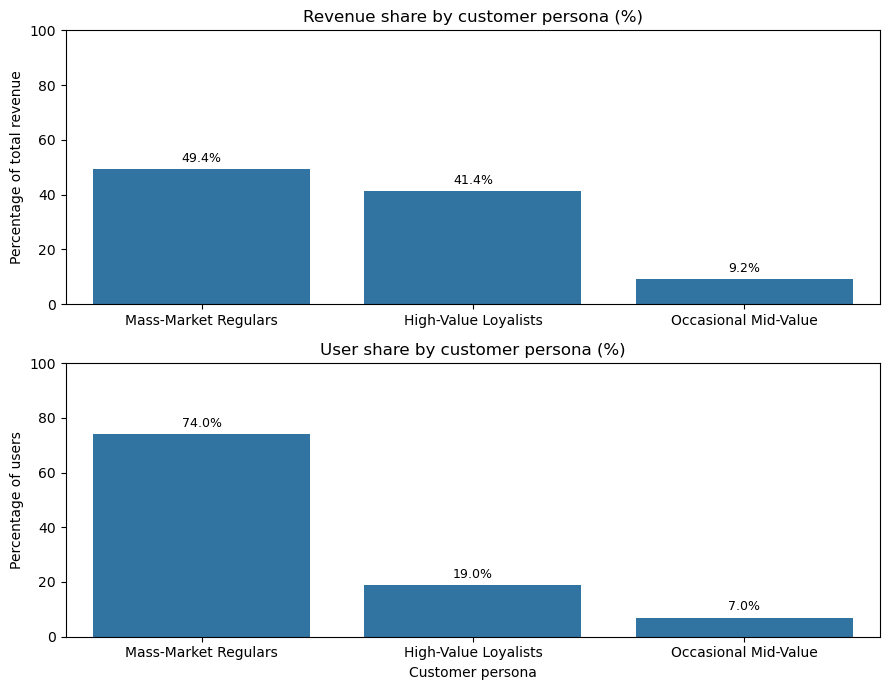

In [49]:
## Visualization: cluster revenue vs users (final layout)
plot_df = clust_summary.reset_index()

plot_df["user_share_pct"] = plot_df["users"] / plot_df["users"].sum() * 100

fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

# Revenue share
sns.barplot(
    data=plot_df,
    x="cluster_name",
    y="revenue_share_pct",
    ax=axes[0]
)
axes[0].set_title("Revenue share by customer persona (%)")
axes[0].set_ylabel("Percentage of total revenue")
axes[0].set_ylim(0, 100)

axes[0].tick_params(axis="x", labelbottom=True)

for p in axes[0].patches:
    h = p.get_height()
    axes[0].annotate(
        f"{h:.1f}%",
        (p.get_x() + p.get_width() / 2, h),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 3),
        textcoords="offset points"
    )

# User share
sns.barplot(
    data=plot_df,
    x="cluster_name",
    y="user_share_pct",
    ax=axes[1]
)
axes[1].set_title("User share by customer persona (%)")
axes[1].set_ylabel("Percentage of users")
axes[1].set_xlabel("Customer persona")
axes[1].set_ylim(0, 100)

for p in axes[1].patches:
    h = p.get_height()
    axes[1].annotate(
        f"{h:.1f}%",
        (p.get_x() + p.get_width() / 2, h),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()
plt.show()

The customer base is dominated by **Mass-Market Regulars**, who account for the majority of users but contribute a disproportionately smaller share of total revenue. In contrast, **High-Value Loyalists** represent a much smaller segment yet generate a substantial portion of overall revenue. **Occasional Mid-Value** customers form a small group with limited impact on total revenue.

This imbalance highlights the importance of targeted strategies that focus on retaining and expanding high-value customers while improving engagement and monetization within the larger mass-market segment.

## Key observation from ML-based customer personas

### Recommended business actions by customer persona

**High-Value Loyalists**
- Prioritize retention through loyalty programs, exclusive offers, and early access to new products.
- Encourage higher lifetime value via premium bundles, cross-selling, and personalized recommendations.
- Monitor churn risk closely, as losing this group would have a disproportionate revenue impact.

**Mass-Market Regulars**
- Focus on increasing purchase frequency through targeted promotions, reminders, and limited-time offers.
- Use onboarding campaigns and personalized messaging to convert repeat buyers into higher-value customers.
- Optimize marketing spend carefully, as this group is large but generates lower revenue per user.

**Occasional Mid-Value**
- Apply reactivation strategies such as win-back campaigns, discounts, or seasonal promotions.
- Test low-cost engagement tactics before allocating significant marketing budget.
- Avoid over-investment, as this segment contributes a relatively small share of total revenue.


### ML-based segmentation vs RFM segmentation

RFM segmentation provides a simple and interpretable framework for understanding customer value based on recency, frequency, and monetary metrics. It is well suited for quick diagnostics, reporting, and rule-based marketing actions.

The machine learning–based segmentation extends this approach by incorporating additional behavioral signals such as basket size, purchase diversity, inter-purchase gaps, and customer tenure. This allows customers with similar RFM scores but different shopping behaviors to be distinguished more effectively.

In this analysis, RFM segmentation is used to establish a baseline understanding of customer value, while ML-based clustering is applied to uncover deeper behavioral patterns and support more nuanced targeting strategies. The two approaches are complementary rather than interchangeable.

### Limitations and assumptions

This analysis is subject to several limitations that should be considered when interpreting the results.

- The segmentation is based on historical transactional data and assumes that past purchasing behavior is indicative of future behavior.
- The machine learning model uses unsupervised clustering, meaning cluster labels are inferred from data patterns rather than predefined business rules.
- Customer behavior is aggregated over a fixed time window; changes in seasonality or long-term trends may alter segment characteristics.
- Some users have limited purchase history, which may reduce the reliability of their assigned segment.
- External factors such as promotions, pricing changes, or market conditions are not explicitly modeled.

These limitations suggest that the segmentation should be periodically refreshed and used in conjunction with business judgment rather than as a standalone decision-making tool.

### Business conclusions and next steps

This analysis set out to understand customer retention behavior, identify high-value customers, and segment the customer base into actionable groups.

Cohort analysis revealed rapid early churn, with only a small fraction of customers returning beyond the first few months. Revenue analysis showed strong concentration, with a small percentage of users accounting for the majority of total sales. RFM segmentation highlighted clear differences in customer value and engagement, while machine learning–based segmentation further refined these insights by capturing behavioral patterns beyond simple recency, frequency, and monetary metrics.

From a business perspective, the results suggest that retention and growth efforts should prioritize high-value customers while selectively investing in strategies to improve engagement among the broader customer base. Reactivation campaigns should be targeted and cost-conscious, given the limited contribution of long-inactive users.

Potential next steps include deploying these segments into a CRM system for campaign targeting, monitoring segment migration over time, refreshing the segmentation on a regular schedule, and evaluating the impact of personalized interventions through controlled experiments such as A/B testing.